## 1. Load Necessary Packages

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
from torch.utils.data import DataLoader, Dataset


# Set the working directory
os.chdir("/Users/Z0026ZG/Work/emg_home")


def compare_predictions(model, test_dataloader, angle_names=None):
    model.eval()
    all_data = {"ts": [], "channel": [], "actual": [], "predicted": []}

    with torch.no_grad():
        for emg_inputs, joint_angles, ts in test_dataloader:
            preds = model(emg_inputs)
            for i in range(joint_angles.shape[1]):
                all_data["actual"].extend(joint_angles[:, i].numpy())
                all_data["predicted"].extend(preds[:, i].numpy())
                all_data["channel"].extend(
                    [angle_names[i] if angle_names else f"angle_{i+1}"]
                    * len(joint_angles)
                )
                all_data["ts"].extend(ts.numpy())

    df = pd.DataFrame(all_data).sort_values(by=["channel", "ts"])
    return df

## 2. Dataset Class

In [ ]:
from torch.utils.data import Dataset
import pandas as pd
import torch


class EMGJointAngleDataset(Dataset):
    def __init__(self, parquet_path, data_indices=None):
        """
        A custom PyTorch Dataset for EMG signal and joint angle prediction.

        Args:
            parquet_path (str): Path to the input .parquet file containing data.
            data_indices (list or array, optional): Indices to subset the dataset (useful for train/val/test splits).
        """
        # Load data from the Parquet file into a DataFrame
        self.data = pd.read_parquet(parquet_path)

        # If specific indices are provided, filter the data accordingly
        if data_indices is not None:
            self.data = self.data.iloc[data_indices].reset_index(drop=True)

        # Define the EMG features used as inputs (lagged versions of 4 EMG channels)
        self.emg_columns = [
            "a1_lag_0", "a1_lag_1", "a1_lag_2", "a1_lag_3", "a1_lag_4",
            "a2_lag_0", "a2_lag_1", "a2_lag_2", "a2_lag_3", "a2_lag_4",
            "a3_lag_0", "a3_lag_1", "a3_lag_2", "a3_lag_3", "a3_lag_4",
            "a4_lag_0", "a4_lag_1", "a4_lag_2", "a4_lag_3", "a4_lag_4",
        ]

        # Define the target joint angle outputs
        self.angle_columns = [
            "thumb_cmc", "index_mcp", "middle_mcp", "ring_mcp", "pinky_mcp",
        ]

        # Check that all required EMG columns are present in the dataset
        missing_emg_cols = [
            col for col in self.emg_columns if col not in self.data.columns
        ]

        # Check that all required joint angle columns are present
        missing_angle_cols = [
            col for col in self.angle_columns if col not in self.data.columns
        ]

        # Raise an error if any required columns are missing
        if missing_emg_cols:
            raise ValueError(f"Missing EMG columns: {missing_emg_cols}")
        if missing_angle_cols:
            raise ValueError(f"Missing joint angle columns: {missing_angle_cols}")

        # Convert EMG inputs to a PyTorch tensor of type float32
        self.emg_inputs = torch.tensor(
            self.data[self.emg_columns].values, dtype=torch.float32
        )

        # Convert joint angle outputs to a tensor
        self.joint_angles = torch.tensor(
            self.data[self.angle_columns].values, dtype=torch.float32
        )

        # Also load the timestamp column as a tensor (if present)
        self.ts = torch.tensor(self.data["ts"].values, dtype=torch.float32)

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.emg_inputs)

    def __getitem__(self, idx):
        """
        Returns a single sample from the dataset at the given index.
        idx = row
        Returns:
            Tuple of (EMG input, joint angle target, timestamp)
        """
        return self.emg_inputs[idx], self.joint_angles[idx], self.ts[idx]

## 3. Basic Multi-layer Perceptron Model

In [ ]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim


class EMGJointAngleMLPModel(pl.LightningModule):
    def __init__(
        self,
        input_size=20,
        output_size=5,
        dropout_prob=0.2,
        nodes=[64, 32],
        use_batch_norm=True,
    ):
        """
        A multi-layer perceptron (MLP) model using PyTorch Lightning
        for predicting joint angles from EMG data.

        Args:
            input_size (int): Number of input features (e.g. EMG channels)
            output_size (int): Number of joint angle outputs
            dropout_prob (float): Dropout probability
            nodes (list): List of node sizes for the two hidden layers
            use_batch_norm (bool): Whether to apply BatchNorm1d after linear layers
        """
        super().__init__()
        self.save_hyperparameters()  # Saves hyperparameters for checkpointing/logging

        self.use_batch_norm = use_batch_norm
        self.relu = nn.ReLU()  # ReLU activation

        # First fully connected layer
        self.fc1 = nn.Linear(input_size, nodes[0])
        self.bn1 = nn.BatchNorm1d(nodes[0]) if use_batch_norm else nn.Identity()
        self.dp1 = nn.Dropout(p=dropout_prob)

        # Second fully connected layer
        self.fc2 = nn.Linear(nodes[0], nodes[1])
        self.bn2 = nn.BatchNorm1d(nodes[1]) if use_batch_norm else nn.Identity()
        self.dp2 = nn.Dropout(p=dropout_prob)

        # Output layer
        self.fc3 = nn.Linear(nodes[1], output_size)

    def forward(self, x):
        """
        Defines the forward pass of the model.
        """
        x = self.relu(self.bn1(self.fc1(x)))  # First layer: Linear -> BatchNorm -> ReLU
        x = self.dp1(x)  # Dropout after first hidden layer

        x = self.relu(
            self.bn2(self.fc2(x))
        )  # Second layer: Linear -> BatchNorm -> ReLU
        x = self.dp2(x)  # Dropout after second hidden layer

        x = self.fc3(x)  # Output layer (no activation, assumes regression)
        return x

    def training_step(self, batch, batch_idx):
        """
        Training step logic. Called once per batch.
        """
        emg_data, joint_angles, ts = batch  # Unpack batch
        predictions = self(emg_data)  # Forward pass
        loss = nn.MSELoss()(predictions, joint_angles)  # Mean Squared Error loss
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)  # Log loss
        return loss

    def validation_step(self, batch, batch_idx):
        """
        Validation step logic. Called once per validation batch.
        """
        emg_data, joint_angles, ts = batch
        predictions = self(emg_data)
        loss = nn.MSELoss()(predictions, joint_angles)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        """
        Test step logic. Called once per test batch.
        """
        emg_data, joint_angles, ts = batch
        predictions = self(emg_data)
        loss = nn.MSELoss()(predictions, joint_angles)
        return loss

    def configure_optimizers(self):
        """
        Setup the optimizer. Adam optimizer with learning rate 1e-3.
        """
        return optim.Adam(self.parameters(), lr=1e-3)

## 4. Train Model

In [ ]:
# from helper import compare_predictions
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import DataLoader

# VLarge 64 -> 1024 -> 512 -> 29
# Large 64 -> 512 -> 256 -> 29
# Small 64 -> 128 -> 64 -> 29

nn_size = "Small"
batch_size = 256
batch_norm = True
max_epochs = 20

# Split dataset into thirds manually
data_size = 22574  # Assuming dataset has 22574 rows
fold_sizes = [data_size // 3] * 3  # Divide data into three parts equally
folds = [
    list(range(i * fold_size, (i + 1) * fold_size))
    for i, fold_size in enumerate(fold_sizes)
]

results = []
for shift in ["09.25_22.75", "10.25_21.75", "11.25_20.75"]:
    for ws in [100, 500]:
        for fold_index in range(3):  # For the first, second, and third 1/3 of the data
            print(f"Fold {fold_index + 1}")

            # Create the model name based on the current fold
            model_name = (
                f"MLP{nn_size}_bs{batch_size}_fold{fold_index + 1}_e{max_epochs}"
            )
            logger = TensorBoardLogger("lightning_logs", name=model_name)

            # Adjust train/validation dataset to use the new fold system (no subjects, no trials)
            train_indices = [
                i for fold in folds if fold != folds[fold_index] for i in fold
            ]
            validation_indices = folds[fold_index]

            # Adjust datasets and dataloaders
            train_dataset = EMGJointAngleDataset(
                data_indices=train_indices,  # Indices instead of subject/trial
                parquet_path=f"data/synced/trial1_5s_{shift}_ws{ws}.parquet",
            )
            validation_dataset = EMGJointAngleDataset(
                data_indices=validation_indices,  # Indices for validation
                parquet_path=f"data/synced/trial1_5s_{shift}_ws{ws}.parquet",
            )
            train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size)
            if nn_size == "VLarge":
                model = EMGJointAngleMLPModel(nodes=[1024, 512], use_batch_norm=batch_norm)
            elif nn_size == "Large":
                model = EMGJointAngleMLPModel(nodes=[512, 256], use_batch_norm=batch_norm)
            elif nn_size == "Medium":
                model = EMGJointAngleMLPModel(nodes=[256, 128], use_batch_norm=batch_norm)
            elif nn_size == "Small":
                model = EMGJointAngleMLPModel(nodes=[128, 64], use_batch_norm=batch_norm)

            # Set up the trainer
            trainer = pl.Trainer(max_epochs=max_epochs, logger=logger)
            trainer.fit(model, train_dataloader, validation_dataloader)

            # Compare predictions and save the results
            test_df = compare_predictions(model, validation_dataloader)
            test_df["ws"] = ws
            test_df["shift"] = shift
            results.append(test_df)

results = pd.concat(results, axis=0)

/var/folders/6q/rq_mdbg94tg05qffjgwg9ckr0000gp/T/ipykernel_77250/1795827514.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


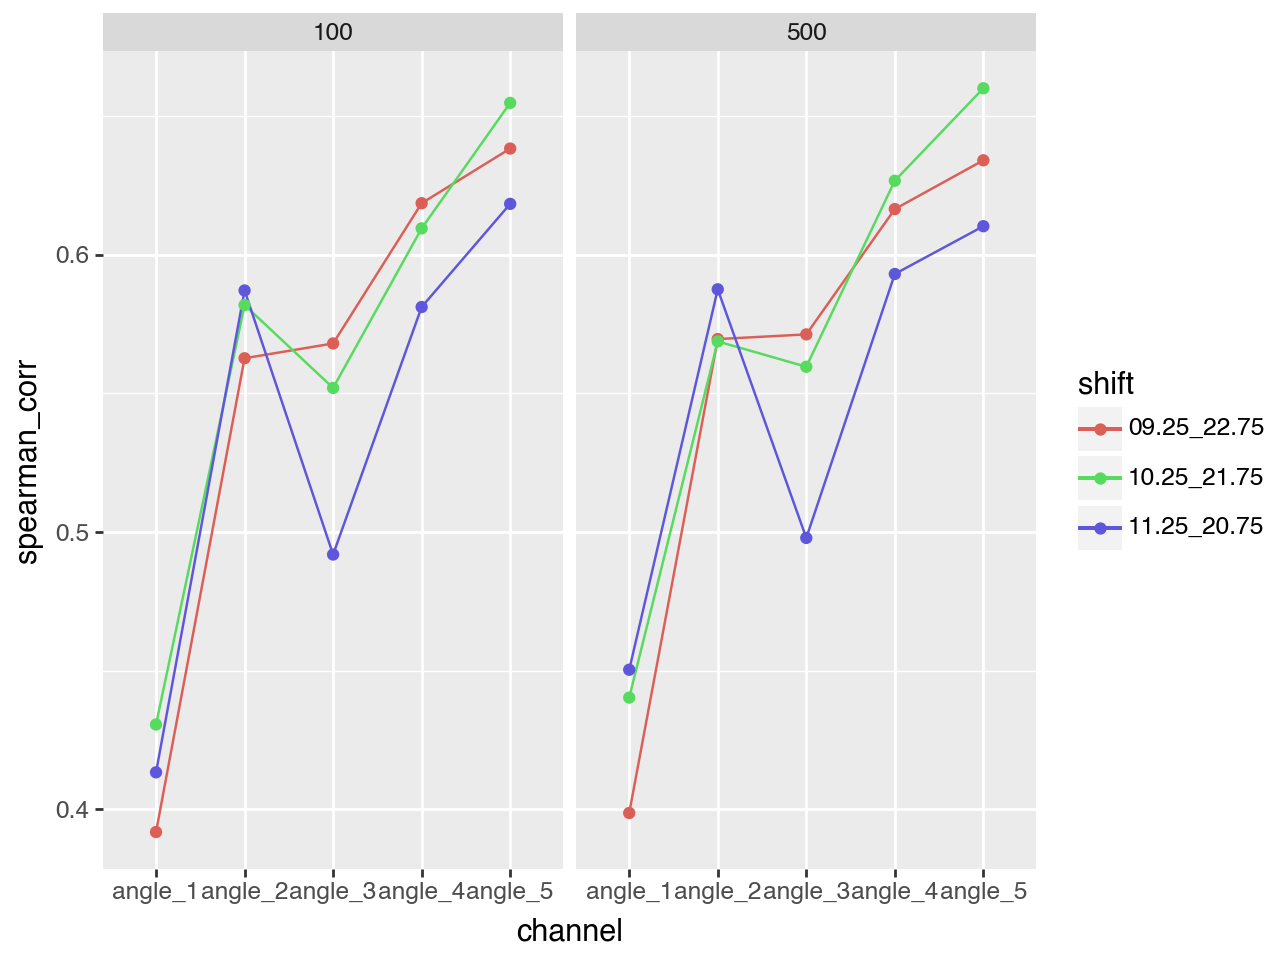

In [165]:
from plotnine import *
from scipy.stats import pearsonr, spearmanr

def calculate_correlations(group):
    pearson_corr, _ = pearsonr(group["actual"], group["predicted"])
    spearman_corr, _ = spearmanr(group["actual"], group["predicted"])
    return pd.Series({"pearson_corr": pearson_corr, "spearman_corr": spearman_corr})

rhos = results.groupby(["ws", "shift", "channel"]).apply(calculate_correlations).reset_index()
(
    ggplot(rhos, aes(x="channel", y="spearman_corr", color="shift", group="shift"))
    + geom_line()
    + geom_point()
    + facet_wrap("ws")
)